In [1]:
import sys
sys.path.insert(0, '../../')
import math
import numpy as np
import matplotlib.pyplot as plt
from gasp import responses, dataset
from gasp import train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_simple, create_data_mask, apply_mask_to_data, extract_centered_subset, process_data_for_gasp, sampling, SSFPParams, train_gasp_with_coils

Data: 20231106_GASP_PHANTOM data exists
pymapVBVD version 0.5.6
Software version: VB


pymapVBVD version 0.5.6
Software version: VB


pymapVBVD version 0.5.6
Software version: VB


(128, 128, 16, 3)


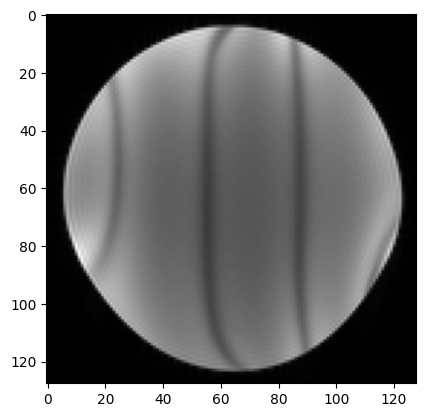

In [2]:
M90 = dataset.load_dataset7a()
M90 = M90[64:192, 64:192, : ,: ,:]
M = np.sqrt(np.sum(np.abs(M90)**2, axis=2))
print(M.shape)
plt.imshow(np.abs(M[:,:,10,2]), cmap='gray')
plt.show()

Data: 20231106_GASP_PHANTOM data exists
pymapVBVD version 0.5.6
Software version: VB


pymapVBVD version 0.5.6
Software version: VB


pymapVBVD version 0.5.6
Software version: VB


(128, 128, 16, 3)


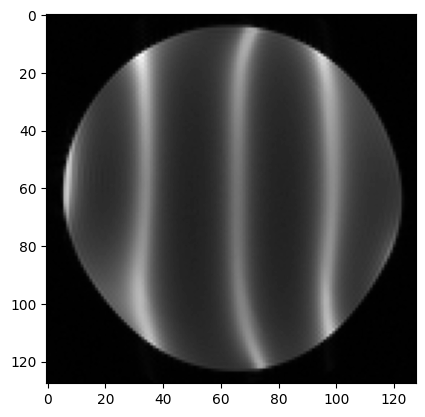

In [3]:
M20 = dataset.load_dataset7b()
M20 = M20[64:192, 64:192, : ,: ,:]
M = np.sqrt(np.sum(np.abs(M20)**2, axis=2))
print(M.shape)
plt.imshow(np.abs(M[:,:,10,2]), cmap='gray')
plt.show()

In [40]:
def run_gasp_with_coils(data, A, method='affine'):
    # Get dimensions
    if data.ndim == 4:
        height, width, ncoils, npcs = data.shape[:]
    if data.ndim == 5:
        height, width, ncoils, npcs, TRs = data.shape[:]
        npcs = npcs * TRs       # Combine PCs and TRs

    out = np.zeros((ncoils, height, width), dtype='complex')
    for cc in range(ncoils):
        single_coil = data[:,:,cc, ...].reshape(height, width, npcs)
        out[cc, ...] = run_gasp(single_coil, A[cc, ...], method=method)
    out = np.sqrt(np.sum(np.abs(out)**2, axis=0))

    return out

def train_model(D, n = 48, alpha = np.deg2rad(20), T2base = 0.01, T1T2ratio = 5.0):
    width = 128
    height = 1
    gradient = 2 * np.pi
    method = 'affine'

    TRs, PCs = sampling.grid_TR_sampling(n_points=n, TRs=[5e-3, 10e-3, 20e-3])
    params = SSFPParams(n, alpha, TRs, PCs)
    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2 = T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
    _, A = train_gasp(M, D, method=method)
    I = run_gasp(M, A, method=method)
    MSE = np.sqrt(np.mean((np.abs(I) - D)**2))
    return A, I, MSE

def train_model_with_phantom(Mdata, D, n_lines=16, method='affine'):

    mask = create_data_mask(Mdata)
    data = apply_mask_to_data(Mdata, mask)
    data_subset = extract_centered_subset(data, n_lines)
    I, A = train_gasp_with_coils(data_subset, D, method=method)
    I = run_gasp_with_coils(data, A, method=method)
    I = I * mask
    MSE = 0
    return A, I, MSE

def train_model_with_sim_run_on_phantom(Mdata, D, n_lines=16, method='affine'):
    # Note: Make sure to run simulation with the same parameters as the training data and TR/PCs are in the same order
    pass

def train_multiple_simulation_models(D, n = 48, alpha = np.deg2rad(20), T2base = 0.01, T1T2ratio = 5.0):
    outputs = []
    A = []
    MSE = []
    for d in D:
        An, output, MSEn = train_model(d, n=n, alpha=alpha, T2base = T2base, T1T2ratio = T1T2ratio)
        outputs.append(output)
        A.append(An)
        MSE.append(MSEn)
    return outputs

def train_multiple_phantom_models(Mdata, D, n_lines=16, method='affine'):
    outputs = []
    A = []
    MSE = []
    for d in D:
        An, output, MSEn = train_model_with_phantom(Mdata, d, n_lines=n_lines, method=method)
        outputs.append(output)
        A.append(An)
        MSE.append(MSEn)
    return outputs




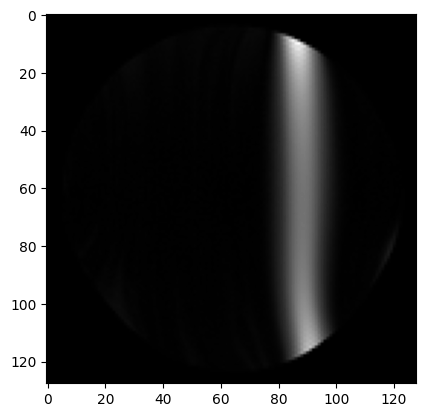

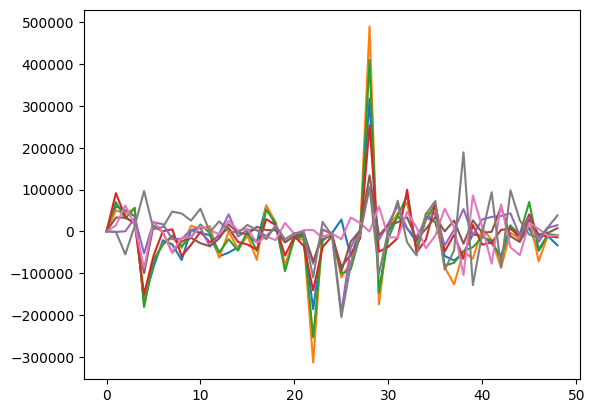

In [53]:
Mdata = M20
width = Mdata.shape[1]

D = responses.gaussian(width, bw=0.1, shift=0.2)
An, output, MSEn = train_model_with_phantom(Mdata, D)
plt.imshow(output, cmap='gray')
plt.show()

plt.plot((An.T))
plt.show()


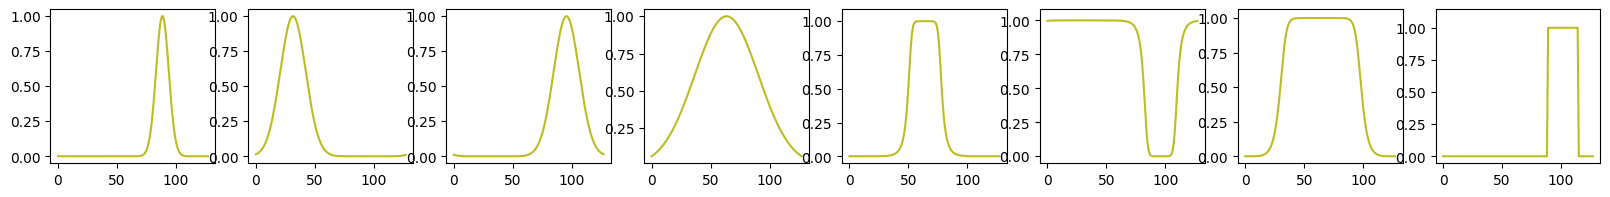

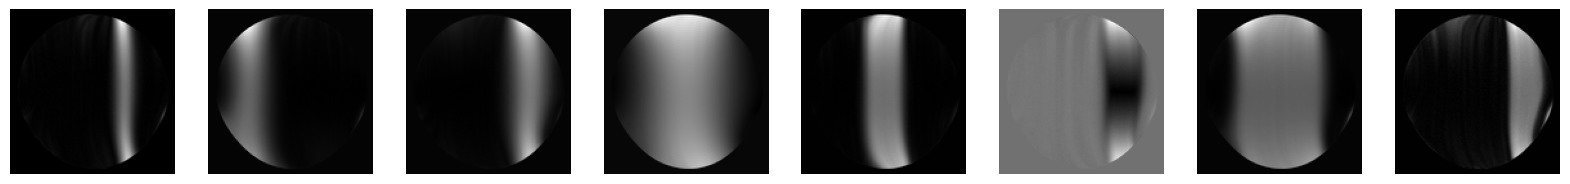

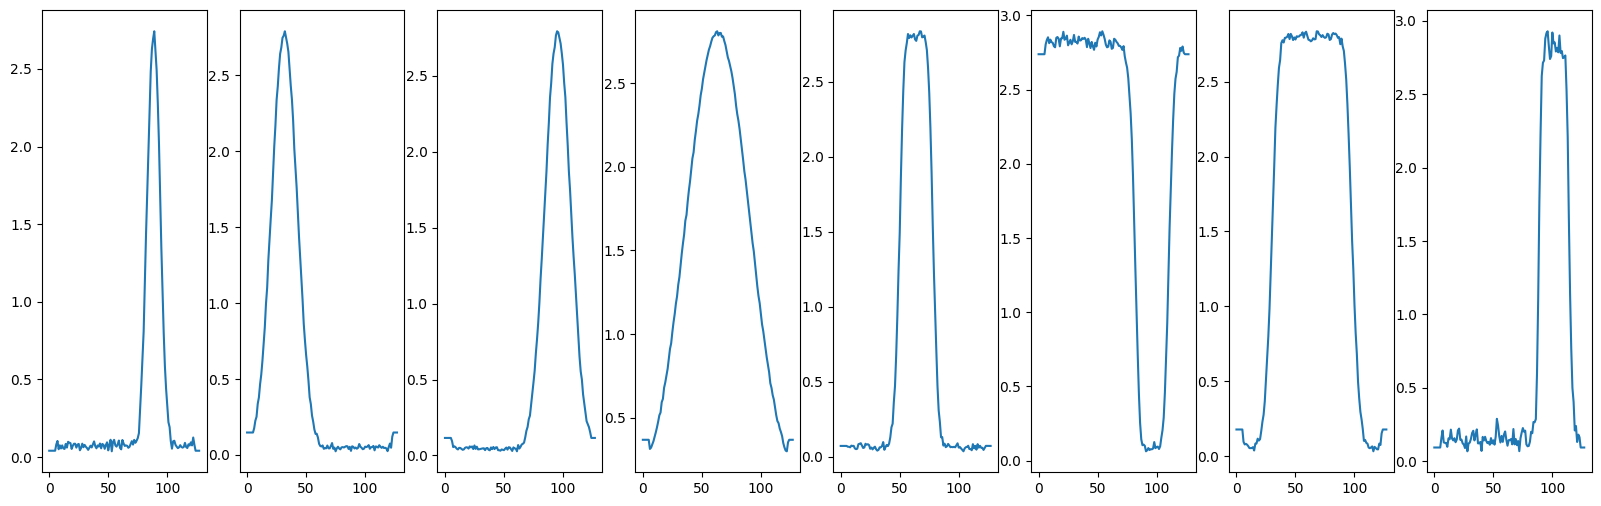

In [42]:
Mdata = M90

D = []
D.append(responses.gaussian(width, bw=0.1, shift=0.2))
D.append(responses.gaussian(width, bw=0.2, shift=-0.25))
D.append(responses.gaussian(width, bw=0.2, shift=0.25))
D.append(responses.gaussian(width, bw=0.5, shift=0))
D.append(responses.bandpass(width, bw=0.2, shift=0))
D.append(responses.stopband(width, bw=0.2, shift=0.25))
D.append(responses.bandpass(width, bw=0.5, shift=0))
D.append(responses.square(width, bw=0.2, shift=0.3))

simulation_outputs = train_multiple_simulation_models(D)
phantom_outputs = train_multiple_phantom_models(Mdata, D, n_lines=16, method='affine')

fig, ax = plt.subplots(1, len(D), figsize=(20, 2))
for i, output in enumerate(simulation_outputs):
    ax[i].plot(np.abs(output))
    ax[i].plot(D[i])
plt.show()

fig, ax = plt.subplots(1, len(D), figsize=(20, 6))
for i, output in enumerate(phantom_outputs):
    ax[i].imshow(np.abs(output), cmap='gray')
    ax[i].axis('off')
plt.show()

fig, ax = plt.subplots(1, len(D), figsize=(20, 6))
for i, output in enumerate(phantom_outputs):
    ax[i].plot(np.abs(output[64,:]))
plt.show()